In [76]:
import torch.nn as nn
from copy import deepcopy
#import torch.nn as nn
#import torchvision
#from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold
import torchvision
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from torch.nn.functional import softmax

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, Subset
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

class JetImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Iterate through the directory to load and label the generated images
        for filename in os.listdir(root_dir):
            if filename.endswith(".png"):
                label = 0 if "type0" in filename else 1  # 0 = gluon, 1 = quark
                self.images.append(filename)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")  # The images are converted to RGB format

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label
    

def load_jet_images(data_dir, img_size=299):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        #transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #transforms.Lambda(lambda x: x.expand(3, -1, -1)),
    ])

    # Load the personalized dataset
    full_dataset = JetImageDataset(root_dir=data_dir, transform=transform)
    labels = np.array(full_dataset.labels)

    # Stratification using sklearn train_test_split
    indices = np.arange(len(full_dataset))

    train_val_indices, test_indices = train_test_split(
        indices,
        test_size=0.2,
        stratify=labels,
        random_state=42
    )

    train_val_set = Subset(full_dataset, train_val_indices)
    test_set = Subset(full_dataset, test_indices)

    return train_val_set, test_set

In [77]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_true, y_probs, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_score_distributions(y_true, y_probs, model_name):
    scores_class0 = y_probs[y_true == 0]
    scores_class1 = y_probs[y_true == 1]
    
    plt.figure(figsize=(8, 6))
    plt.hist(scores_class0, bins=50, alpha=0.5, label='Gluon', color='blue')
    plt.hist(scores_class1, bins=50, alpha=0.5, label='Top Quark', color='red')
    plt.xlabel('Classifier Score')
    plt.ylabel('Count')
    plt.title(f'Score Distributions - {model_name}')
    plt.legend(loc='upper right')
    plt.show()

In [78]:
class EnsembleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet50 = torchvision.models.resnet50(pretrained=True)
        self.inceptionv3 = torchvision.models.inception_v3(pretrained=True, aux_logits=True)
        
        # Modify the input layer of ResNet50
        self.resnet50.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Specific Configuration for InceptionV3:
        # Disable automatic input transformationn        self.inceptionv3.transform_input = False
        # Modify the first layer to acept 3 chanels (without editing Conv2d_1a_3x3 directly)
        original_first_conv = self.inceptionv3.Conv2d_1a_3x3.conv
        self.inceptionv3.Conv2d_1a_3x3.conv = nn.Conv2d(
            in_channels=3,  # Changed to 3 canales
            out_channels=original_first_conv.out_channels,
            kernel_size=original_first_conv.kernel_size,
            stride=original_first_conv.stride,
            padding=original_first_conv.padding,
            bias=False
        )
        
        with torch.no_grad():
            # # Average the weights across the RGB channels and replicate
            weights_1ch = original_first_conv.weight.mean(dim=1, keepdim=True)
            self.inceptionv3.Conv2d_1a_3x3.conv.weight = nn.Parameter(weights_1ch.repeat(1,3,1,1))
        #with torch.no_grad():
        #    self.inceptionv3.Conv2d_1a_3x3.conv.weight[:, :1] = original_first_conv.weight.clone()
        #    self.inceptionv3.Conv2d_1a_3x3.conv.weight[:, 1:] = original_first_conv.weight[:, :1].repeat(1,2,1,1)
        
        # Perform selective parameter freezing
        for param in self.resnet50.parameters():
            param.requires_grad = False
        for param in self.inceptionv3.parameters():
            param.requires_grad = False
            
        # Unfreeze the final layers
        for param in list(self.resnet50.parameters())[-50:]:
            param.requires_grad = True
        for param in list(self.inceptionv3.parameters())[-30:]:
            param.requires_grad = True

        # Replace the fully connected layers
        self.resnet50.fc = nn.Identity()  # Extrat 2048 features
        self.inceptionv3.fc = nn.Identity()  # Extrat 2048 features
        
        # Attention mechanism for feature fusion
        self.attention = nn.Sequential(
            nn.Linear(2048*2, 512),  # 2048 of ResNet + 2048 of Inception
            nn.ReLU(),
            nn.Linear(512, 2048*2),
            nn.Sigmoid()  # Sigmoide activation atenttion (0-1)
        )
        
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(2048*2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout alto para regularización
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)  # Salida binaria
        )

    def forward(self, x):
        # Process with both models
        features_resnet = self.resnet50(x)
        features_inception = self.inceptionv3(x)
        
        # InceptionV3 return a tuple (output, aux_output) if aux_logits=True
        if isinstance(features_inception, tuple):
            features_inception = features_inception[0]  # Take the principal output
        
        combined = torch.cat((features_resnet, features_inception), dim=1)
        # Calculate attention weights (batch_size x 4096)
        attention_weights = self.attention(combined)
        
        # Apply attention (multiplication element-wise)
        attended_features = combined * attention_weights
        
        # final Clasification
        out = self.classifier(attended_features)
        return out

In [79]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_labels = []
    incept_preds = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        incept_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        

    train_accuracy = correct_train / total_train
    return running_loss / len(train_loader), train_accuracy

from sklearn.metrics import accuracy_score 
def test_model(model, test_loader, device):
    model.eval()
    correct_test = 0
    total_test = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilidad clase 1

    test_accuracy = correct_test / total_test
    test_auc = roc_auc_score(all_labels, all_probs)
    return test_accuracy, test_auc, all_labels, all_probs



In [ ]:
def validate_model_individuals(model, val_loader, criterion, device, target_tpr=0.5):
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    incept_preds = []
    incept_confidences = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Obtén la confianza de cada modelo
            #incept_confidences.append(softmax(outputs, dim=1).cpu().numpy())
            # Manejar salida de InceptionV3
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Tomar la salida principal
            
            # Calcular probabilidades con softmax y guardar confianzas de la CLASE POSITIVA (índice 1)
            confidences = softmax(outputs, dim=1).cpu().numpy()
            incept_confidences.append(confidences[:, 1])  # Cambio clave: usar solo clase positiva

            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            incept_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            
    val_accuracy = correct_val / total_val
    #cm_incept = confusion_matrix(all_labels, incept_preds)

    predicted_probs = np.concatenate(incept_confidences)  # Ya son solo las de clase positiva



    return running_loss / len(val_loader), val_accuracy, all_labels, predicted_probs

In [ ]:
def validate_ensemble(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass con el ensemble completo
            outputs = model(inputs)
            
            # Manejo de salidas (para InceptionV3 en el ensemble)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Tomamos la salida principal
            
            # Cálculo de pérdida y métricas
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Obtención de predicciones
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            # Almacenamiento para métricas
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilidad clase positiva
            
    # Cálculo de métricas finales
    val_loss = running_loss / len(val_loader)
    val_accuracy = correct / total
    val_auc = roc_auc_score(all_labels, all_probs)
    
    return val_loss, val_accuracy, val_auc, all_labels, all_probs


In [81]:
from torch.cuda.amp import GradScaler, autocast
import time
def cross_validate_ensemble(train_val_set, test_set, k_folds=10, epochs=30, batch_size=64):
    # Obtener etiquetas para estratificación
    labels = [train_val_set[i][1] for i in range(len(train_val_set))]
    
    # Usar StratifiedKFold para mantener proporción de clases
    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nDispositivo de entrenamiento: {device}") 

    final_model = EnsembleModel().to(device)
    if torch.cuda.device_count() > 1:
        final_model = nn.DataParallel(final_model)
    
    # 3. Listas para métricas
    fold_metrics = {
        'train_acc': [],
        'val_acc': [],
        'models': []  # Para almacenar los modelos de cada fold
    }

    # Configuración de entrenamiento mejorada
    train_accuracies, val_accuracies, test_accuracy = [], [], []
    all_labels = []
    all_probs = []
    best_models = []  # Para guardar los mejores modelos de cada fold

    # Early stopping config
    patience = 5
    min_delta = 0.005

    for fold, (train_ids, val_ids) in enumerate(kfold.split(range(len(train_val_set)), labels)):
        print(f'\n{"="*50}\nTraining on Fold {fold + 1}/{k_folds}\n{"="*50}')
        
        # DataLoaders optimizados
        train_loader = DataLoader(
            train_val_set,
            batch_size=batch_size,
            sampler=SubsetRandomSampler(train_ids),
            num_workers=min(4, os.cpu_count()),
            pin_memory=True,
            persistent_workers=True
        )
        
        val_loader = DataLoader(
            train_val_set,
            batch_size=batch_size*2,
            sampler=SubsetRandomSampler(val_ids),
            num_workers=min(4, os.cpu_count()),
            pin_memory=True
        )

        # Inicializar modelo mejorado
        model = EnsembleModel()
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
        model.to(device)
        
        # Optimizador y scheduler mejorados
        optimizer = optim.AdamW([
            {'params': [p for p in model.module.resnet50.parameters() if p.requires_grad], 'lr': 1e-5},
            {'params': [p for p in model.module.inceptionv3.parameters() if p.requires_grad], 'lr': 1e-5},
            {'params': model.module.attention.parameters(), 'lr': 3e-4},
            {'params': model.module.classifier.parameters(), 'lr': 1e-3}
        ], weight_decay=1e-4)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='max', 
            factor=0.5, 
            patience=2, 
            verbose=True
        )

        # Loss function con label smoothing
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        # Early stopping variables
        best_val_acc = 0.0
        early_stop_counter = 0
        best_model_state = None

        for epoch in range(epochs):
            start_time = time.time()
            
            # Entrenamiento
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            
            # Validación
            val_loss, val_acc, val_labels, val_probs = validate_ensemble(
                model, val_loader, criterion, device
            )

            # Actualizar scheduler basado en val_acc
            scheduler.step(val_acc)
            
            # Calcular tiempo de época
            epoch_time = time.time() - start_time
            
            print(f'Epoch {epoch + 1}/{epochs} | Time: {epoch_time:.2f}s')
            print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
            
            # Early stopping logic
            if val_acc > best_val_acc + min_delta:
                best_val_acc = val_acc
                early_stop_counter = 0
                best_model_state = deepcopy(model.state_dict())
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f'Early stopping triggered at epoch {epoch + 1}!')
                    model.load_state_dict(best_model_state)
                    break

        # Almacenar resultados del fold
        fold_metrics['train_acc'].append(train_acc)
        fold_metrics['val_acc'].append(val_acc)
        fold_metrics['models'].append(best_model_state)
        # Guardar mejor modelo del fold

        #best_models.append(deepcopy(model.state_dict()))
        

        
        # Almacenar resultados
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        all_labels.extend(val_labels)
        all_probs.extend(val_probs)
        
        print(f'\nFold {fold + 1} Results:')
        print(f'Best Val Acc: {best_val_acc:.4f}')

    test_loader = DataLoader(
            test_set,
            batch_size=batch_size*2,
            shuffle=False,
            num_workers=min(4, os.cpu_count()),
            pin_memory=True
        )

    # Evaluación en test set
    test_acc, test_auc, true_labels, test_probs = test_model(fold_metrics['models'], test_loader, device)
            
    test_accuracy.append(test_acc)
    # Resultados finales
    avg_train_acc = np.mean(train_accuracies)
    avg_val_acc = np.mean(val_accuracies)
    #avg_test_acc = np.mean(test_accuracies)
    
    print(f'\n{"="*50}')
    print(f'Cross-Validation Complete')
    print(f'Average Training Accuracy: {avg_train_acc:.4f}')
    print(f'Average Validation Accuracy: {avg_val_acc:.4f}')
    print(f'Average Testing Accuracy: {test_accuracy:.4f}')
    print(f'{"="*50}')
    
    return avg_train_acc, avg_val_acc, test_accuracy, all_labels, all_probs, test_auc, true_labels, test_probs

In [20]:
from torch.cuda.amp import GradScaler, autocast
import time
# Validación cruzada del modelo de ensamble sin ViT
def cross_validate_ensemble(train_val_set, test_set, k_folds=10, epochs=30, batch_size=256):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if torch.cuda.is_available():
        print(f"\nGPUs disponibles: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

    train_accuracies, val_accuracies, test_accuracies = [], [], []
    CM_incept = []
    incept_rejection_rates = []
    
    # Listas para almacenar todas las probabilidades y etiquetas de validación
    all_labels = []
    all_probs = []  # Ahora almacenará SOLO las probabilidades de la clase positiva

    patience = 2  # Número de épocas sin mejora antes de parar
    min_delta = 0.001  # Cambio mínimo para considerar mejora
    best_val_loss = float('inf')
    early_stop_counter = 0

    for fold, (train_ids, val_ids) in enumerate(kfold.split(train_val_set)):
        #print(f'\nTraining on Fold {fold + 1}...')
        print(f'\n{"="*50}\nFold {fold + 1}/{k_folds}\n{"="*50}')
        
        # DataLoaders optimizados
        train_loader = DataLoader(
            train_val_set,
            batch_size=batch_size,
            sampler=SubsetRandomSampler(train_ids),
            num_workers=min(4, os.cpu_count()),
            pin_memory=True,
            persistent_workers=True
        )
        
        val_loader = DataLoader(
            train_val_set,
            batch_size=batch_size*2,  # Mayor batch_size para validación
            sampler=SubsetRandomSampler(val_ids),
            num_workers=min(4, os.cpu_count()),
            pin_memory=True
        )
        
        test_loader = DataLoader(
            test_set,
            batch_size=batch_size*2,
            shuffle=False,
            num_workers=min(4, os.cpu_count()),
            pin_memory=True
        )

        # Modelo y optimizador
        model = EnsembleModel()
        if torch.cuda.device_count() > 1:
            print(f"Usando {torch.cuda.device_count()} GPUs con DataParallel")
            model = nn.DataParallel(model)
        model.to(device)
        
        criterion = nn.CrossEntropyLoss()
        # Reemplazar tu optimizer actual por:
        optimizer = optim.AdamW([
            {'params': [p for p in model.resnet50.parameters() if p.requires_grad], 'lr': 1e-5},
            {'params': [p for p in model.inceptionv3.parameters() if p.requires_grad], 'lr': 1e-5},
            {'params': model.attention.parameters(), 'lr': 3e-4},
            {'params': model.classifier.parameters(), 'lr': 1e-3}
        ], weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='max', 
            factor=0.5, 
            patience=3, 
            verbose=True
        )
        #optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
        #scaler = GradScaler()  # Para mixed-precision
        
        # Early Stopping variables
        best_val_loss = float('inf')
        early_stop_counter = 0
        best_model_state = None

        for epoch in range(epochs):
            start_time = time.time()
            epoch_time = time.time() - start_time
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)

            val_loss, val_acc, val_labels, val_probs = validate_model_individuals(model, val_loader, criterion, device)
            
            print(f'Epoch {epoch + 1}/{epochs} |  Time: {epoch_time:.2f}s | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} '
                  f'| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
            #print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
            

            # Early Stopping Logic
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                early_stop_counter = 0
                best_model_weights = model.state_dict().copy()  # Guardar mejor modelo
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f'Early stopping triggered at epoch {epoch + 1}!')
                    model.load_state_dict(best_model_weights)  # Restaurar mejor modelo
                    break


        #incept_rejection_rates.append(incept_rejection_rate)
        #CM_incept.append(val_cm_incept)
        
        # Almacenar etiquetas y probabilidades CORRECTAS (clase positiva)
        all_labels.extend(val_labels)
        all_probs.extend(val_probs)  # val_probs ahora son las probabilidades de la clase 1
        scheduler.step(val_acc)

        val_accuracies.append(val_acc)
        train_accuracies.append(train_acc)

        # Evaluar y obtener tasa de rechazo del modelo de ensamble en el test set
        test_acc, test_auc, true_all_labels, test_all_probs = test_model(model, test_loader, device)
        test_accuracies.append(test_acc)

    avg_train_accuracy = np.mean(train_accuracies)
    avg_val_accuracy = np.mean(val_accuracies)
    avg_test_accuracy = np.mean(test_accuracies)

    # Promedio de matrices de confusión (suma en lugar de promedio)
    #avg_cm_incept = np.sum(CM_incept, axis=0)  # Más informativo que el promedio

    #avg_incept_rejection = np.mean(incept_rejection_rates)
    

    print(f'\nAverage Training Accuracy: {avg_train_accuracy:.4f}')
    print(f'Average Validation Accuracy: {avg_val_accuracy:.4f}')
    print(f'Average Testing Accuracy: {avg_test_accuracy:.4f}')


    return avg_train_accuracy, avg_val_accuracy, avg_test_accuracy, all_labels, all_probs, test_auc, true_all_labels, test_all_probs


Dispositivo de entrenamiento: cuda

Training on Fold 1/10


/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights

Epoch 1/30 | Time: 872.90s
Train Loss: 0.5914 | Train Acc: 0.7215
Val Loss: 0.5792 | Val Acc: 0.7493
Epoch 2/30 | Time: 850.94s
Train Loss: 0.5585 | Train Acc: 0.7520
Val Loss: 0.5566 | Val Acc: 0.7532
Epoch 3/30 | Time: 857.18s
Train Loss: 0.5340 | Train Acc: 0.7729
Val Loss: 0.5597 | Val Acc: 0.7471
Epoch 4/30 | Time: 857.22s
Train Loss: 0.4964 | Train Acc: 0.8046
Val Loss: 0.5739 | Val Acc: 0.7428
Epoch 5/30 | Time: 856.72s
Train Loss: 0.4408 | Train Acc: 0.8489
Val Loss: 0.6112 | Val Acc: 0.7312
Epoch 6/30 | Time: 855.27s
Train Loss: 0.3528 | Train Acc: 0.9103
Val Loss: 0.7043 | Val Acc: 0.7023
Early stopping triggered at epoch 6!

Fold 1 Results:
Best Val Acc: 0.7493
Test Acc: 0.7453 | Test AUC: 0.8116

Training on Fold 2/10


/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights

Epoch 1/30 | Time: 860.11s
Train Loss: 0.5936 | Train Acc: 0.7175
Val Loss: 0.5690 | Val Acc: 0.7388
Epoch 2/30 | Time: 862.14s
Train Loss: 0.5595 | Train Acc: 0.7492
Val Loss: 0.5609 | Val Acc: 0.7446
Epoch 3/30 | Time: 861.25s
Train Loss: 0.5325 | Train Acc: 0.7737
Val Loss: 0.5666 | Val Acc: 0.7433
Epoch 4/30 | Time: 851.28s
Train Loss: 0.4899 | Train Acc: 0.8098
Val Loss: 0.5907 | Val Acc: 0.7263
Epoch 5/30 | Time: 849.52s
Train Loss: 0.4299 | Train Acc: 0.8557
Val Loss: 0.6331 | Val Acc: 0.7130
Epoch 6/30 | Time: 849.20s
Train Loss: 0.3381 | Train Acc: 0.9191
Val Loss: 0.7170 | Val Acc: 0.7134
Epoch 7/30 | Time: 866.80s
Train Loss: 0.2955 | Train Acc: 0.9471
Val Loss: 0.7801 | Val Acc: 0.6936
Early stopping triggered at epoch 7!

Fold 2 Results:
Best Val Acc: 0.7446
Test Acc: 0.7473 | Test AUC: 0.8170

Training on Fold 3/10


/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights

Epoch 1/30 | Time: 872.03s
Train Loss: 0.5915 | Train Acc: 0.7213
Val Loss: 0.5744 | Val Acc: 0.7383
Epoch 2/30 | Time: 847.83s
Train Loss: 0.5573 | Train Acc: 0.7533
Val Loss: 0.5597 | Val Acc: 0.7479
Epoch 3/30 | Time: 847.63s
Train Loss: 0.5313 | Train Acc: 0.7761
Val Loss: 0.5709 | Val Acc: 0.7384
Epoch 4/30 | Time: 853.87s
Train Loss: 0.4933 | Train Acc: 0.8081
Val Loss: 0.5934 | Val Acc: 0.7334
Epoch 5/30 | Time: 865.92s
Train Loss: 0.4388 | Train Acc: 0.8505
Val Loss: 0.6540 | Val Acc: 0.7042
Epoch 6/30 | Time: 864.27s
Train Loss: 0.3507 | Train Acc: 0.9115
Val Loss: 0.7247 | Val Acc: 0.7033
Epoch 7/30 | Time: 845.95s
Train Loss: 0.3070 | Train Acc: 0.9402
Val Loss: 0.7891 | Val Acc: 0.6929
Early stopping triggered at epoch 7!

Fold 3 Results:
Best Val Acc: 0.7479
Test Acc: 0.7508 | Test AUC: 0.8195

Training on Fold 4/10


/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights

Epoch 1/30 | Time: 851.55s
Train Loss: 0.5904 | Train Acc: 0.7204
Val Loss: 0.5634 | Val Acc: 0.7443
Epoch 2/30 | Time: 858.53s
Train Loss: 0.5562 | Train Acc: 0.7527
Val Loss: 0.5620 | Val Acc: 0.7431
Epoch 3/30 | Time: 849.85s
Train Loss: 0.5310 | Train Acc: 0.7753
Val Loss: 0.5638 | Val Acc: 0.7451
Epoch 4/30 | Time: 849.80s
Train Loss: 0.4915 | Train Acc: 0.8083
Val Loss: 0.5921 | Val Acc: 0.7367
Epoch 5/30 | Time: 850.46s
Train Loss: 0.4333 | Train Acc: 0.8536
Val Loss: 0.6342 | Val Acc: 0.7203
Epoch 6/30 | Time: 869.59s
Train Loss: 0.3698 | Train Acc: 0.8978
Val Loss: 0.6958 | Val Acc: 0.7052
Early stopping triggered at epoch 6!

Fold 4 Results:
Best Val Acc: 0.7443
Test Acc: 0.7473 | Test AUC: 0.8159

Training on Fold 5/10


/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights

Epoch 1/30 | Time: 868.03s
Train Loss: 0.5891 | Train Acc: 0.7236
Val Loss: 0.5652 | Val Acc: 0.7462
Epoch 2/30 | Time: 850.93s
Train Loss: 0.5576 | Train Acc: 0.7526
Val Loss: 0.5534 | Val Acc: 0.7526
Epoch 3/30 | Time: 850.39s
Train Loss: 0.5310 | Train Acc: 0.7760
Val Loss: 0.5555 | Val Acc: 0.7511
Epoch 4/30 | Time: 850.98s
Train Loss: 0.4918 | Train Acc: 0.8084
Val Loss: 0.5701 | Val Acc: 0.7424
Epoch 5/30 | Time: 852.41s
Train Loss: 0.4328 | Train Acc: 0.8536
Val Loss: 0.6265 | Val Acc: 0.7326
Epoch 6/30 | Time: 874.34s
Train Loss: 0.3425 | Train Acc: 0.9164
Val Loss: 0.7071 | Val Acc: 0.7105
Epoch 7/30 | Time: 861.92s
Train Loss: 0.2989 | Train Acc: 0.9447
Val Loss: 0.7377 | Val Acc: 0.7104
Early stopping triggered at epoch 7!

Fold 5 Results:
Best Val Acc: 0.7526
Test Acc: 0.7505 | Test AUC: 0.8209

Training on Fold 6/10


/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights

Epoch 1/30 | Time: 850.19s
Train Loss: 0.5902 | Train Acc: 0.7209
Val Loss: 0.5633 | Val Acc: 0.7457
Epoch 2/30 | Time: 849.00s
Train Loss: 0.5573 | Train Acc: 0.7528
Val Loss: 0.5578 | Val Acc: 0.7490
Epoch 3/30 | Time: 848.83s
Train Loss: 0.5308 | Train Acc: 0.7759
Val Loss: 0.5633 | Val Acc: 0.7485
Epoch 4/30 | Time: 853.29s
Train Loss: 0.4892 | Train Acc: 0.8101
Val Loss: 0.5909 | Val Acc: 0.7373
Epoch 5/30 | Time: 865.39s
Train Loss: 0.4291 | Train Acc: 0.8569
Val Loss: 0.6257 | Val Acc: 0.7283
Epoch 6/30 | Time: 865.44s
Train Loss: 0.3391 | Train Acc: 0.9197
Val Loss: 0.7254 | Val Acc: 0.7032
Early stopping triggered at epoch 6!

Fold 6 Results:
Best Val Acc: 0.7457
Test Acc: 0.7466 | Test AUC: 0.8127

Training on Fold 7/10


/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights

Epoch 1/30 | Time: 848.72s
Train Loss: 0.5922 | Train Acc: 0.7194
Val Loss: 0.5658 | Val Acc: 0.7416
Epoch 2/30 | Time: 849.25s
Train Loss: 0.5591 | Train Acc: 0.7503
Val Loss: 0.5577 | Val Acc: 0.7494
Epoch 3/30 | Time: 858.32s
Train Loss: 0.5332 | Train Acc: 0.7731
Val Loss: 0.5627 | Val Acc: 0.7414
Epoch 4/30 | Time: 863.70s
Train Loss: 0.4950 | Train Acc: 0.8058
Val Loss: 0.5858 | Val Acc: 0.7372
Epoch 5/30 | Time: 856.48s
Train Loss: 0.4383 | Train Acc: 0.8497
Val Loss: 0.6262 | Val Acc: 0.7252
Epoch 6/30 | Time: 846.91s
Train Loss: 0.3487 | Train Acc: 0.9124
Val Loss: 0.7163 | Val Acc: 0.6957
Epoch 7/30 | Time: 849.01s
Train Loss: 0.3038 | Train Acc: 0.9421
Val Loss: 0.7760 | Val Acc: 0.6985
Early stopping triggered at epoch 7!

Fold 7 Results:
Best Val Acc: 0.7494
Test Acc: 0.7504 | Test AUC: 0.8196

Training on Fold 8/10


/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights

Epoch 1/30 | Time: 852.56s
Train Loss: 0.5901 | Train Acc: 0.7222
Val Loss: 0.5625 | Val Acc: 0.7455
Epoch 2/30 | Time: 849.23s
Train Loss: 0.5573 | Train Acc: 0.7529
Val Loss: 0.5572 | Val Acc: 0.7502
Epoch 3/30 | Time: 853.87s
Train Loss: 0.5324 | Train Acc: 0.7750
Val Loss: 0.5597 | Val Acc: 0.7466
Epoch 4/30 | Time: 874.92s
Train Loss: 0.4926 | Train Acc: 0.8078
Val Loss: 0.5818 | Val Acc: 0.7364
Epoch 5/30 | Time: 870.67s
Train Loss: 0.4358 | Train Acc: 0.8522
Val Loss: 0.6413 | Val Acc: 0.7272
Epoch 6/30 | Time: 856.71s
Train Loss: 0.3468 | Train Acc: 0.9142
Val Loss: 0.7100 | Val Acc: 0.7117
Early stopping triggered at epoch 6!

Fold 8 Results:
Best Val Acc: 0.7455
Test Acc: 0.7452 | Test AUC: 0.8120

Training on Fold 9/10


/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights

Epoch 1/30 | Time: 853.62s
Train Loss: 0.5924 | Train Acc: 0.7201
Val Loss: 0.5659 | Val Acc: 0.7401
Epoch 2/30 | Time: 861.26s
Train Loss: 0.5590 | Train Acc: 0.7510
Val Loss: 0.5601 | Val Acc: 0.7502
Epoch 3/30 | Time: 876.35s
Train Loss: 0.5326 | Train Acc: 0.7750
Val Loss: 0.5603 | Val Acc: 0.7481
Epoch 4/30 | Time: 864.47s
Train Loss: 0.4912 | Train Acc: 0.8093
Val Loss: 0.5973 | Val Acc: 0.7375
Epoch 5/30 | Time: 855.34s
Train Loss: 0.4318 | Train Acc: 0.8554
Val Loss: 0.6475 | Val Acc: 0.7061
Epoch 6/30 | Time: 852.68s
Train Loss: 0.3419 | Train Acc: 0.9171
Val Loss: 0.7110 | Val Acc: 0.7135
Epoch 7/30 | Time: 846.99s
Train Loss: 0.2997 | Train Acc: 0.9449
Val Loss: 0.7586 | Val Acc: 0.7051
Early stopping triggered at epoch 7!

Fold 9 Results:
Best Val Acc: 0.7502
Test Acc: 0.7469 | Test AUC: 0.8169

Training on Fold 10/10


/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights

Epoch 1/30 | Time: 848.29s
Train Loss: 0.5861 | Train Acc: 0.7273
Val Loss: 0.5676 | Val Acc: 0.7447
Epoch 2/30 | Time: 853.48s
Train Loss: 0.5557 | Train Acc: 0.7544
Val Loss: 0.5566 | Val Acc: 0.7512
Epoch 3/30 | Time: 868.36s
Train Loss: 0.5315 | Train Acc: 0.7761
Val Loss: 0.5722 | Val Acc: 0.7385
Epoch 4/30 | Time: 853.98s
Train Loss: 0.4929 | Train Acc: 0.8080
Val Loss: 0.5876 | Val Acc: 0.7400
Epoch 5/30 | Time: 848.02s
Train Loss: 0.4359 | Train Acc: 0.8521
Val Loss: 0.6186 | Val Acc: 0.7305
Epoch 6/30 | Time: 847.02s
Train Loss: 0.3478 | Train Acc: 0.9135
Val Loss: 0.6876 | Val Acc: 0.7125
Epoch 7/30 | Time: 856.63s
Train Loss: 0.3050 | Train Acc: 0.9412
Val Loss: 0.7344 | Val Acc: 0.7208
Early stopping triggered at epoch 7!

Fold 10 Results:
Best Val Acc: 0.7512
Test Acc: 0.7516 | Test AUC: 0.8214

Cross-Validation Complete
Average Training Accuracy: 0.9302
Average Validation Accuracy: 0.7044
Average Testing Accuracy: 0.7482


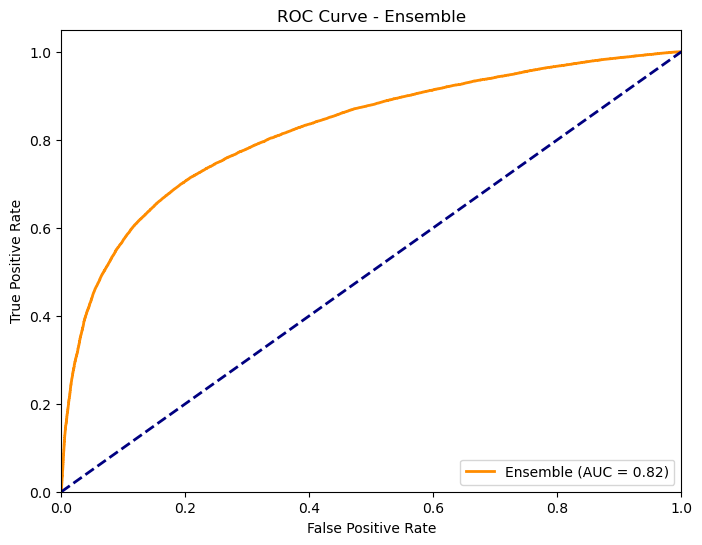

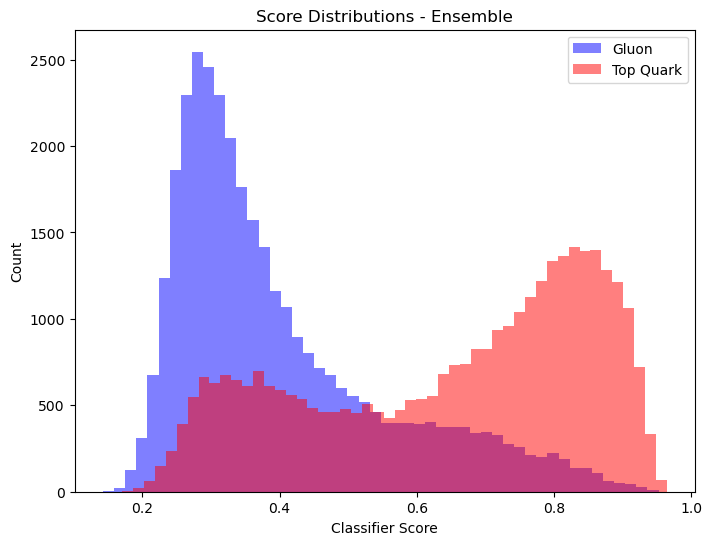

In [82]:
data_dir = './data/Jet2Image_g-q_170k'  # Cambia esto según la ubicación de tus imágenes

# Cargando el dataset con la función corregida
train_val_set, test_set = load_jet_images(data_dir)
#train_val_set, test_set = load_cifar10()
Train_accuracy_avg, validation_accuracy_avg, Testing_avg_acc, all_labels, all_probs, test_auc, true_all_labels, test_all_probs  = cross_validate_ensemble(train_val_set, test_set)

y_true = np.array(true_all_labels)
y_pred = np.array(test_all_probs)
# Generar gráficos con TODOS los datos de validación
#plot_roc_curve(y_true, y_pred, "Inception-V3")
plot_roc_curve(y_true, y_pred, "Ensemble")
#plot_score_distributions(y_true, y_pred, "Inception-V3")
plot_score_distributions(y_true, y_pred, "Ensemble")
# Ejemplo: Supongamos que tienes esto después de evaluar tu modelo
#model_name = "inception-v3"  # Cambia esto según corresponda
model_name = "ensemble"
np.savez(f'{model_name}_results_g-q.npz', y_true=y_true, y_pred=y_pred)